# Transcribe long audio

<div class="alert alert-info">

This tutorial is available as an IPython notebook at [malaya-speech/example/transcribe-long-audio](https://github.com/huseinzol05/malaya-speech/tree/master/example/transcribe-long-audio).
    
</div>

<div class="alert alert-warning">

This module is not language independent, so it not save to use on different languages. Pretrained models trained on hyperlocal languages.
    
</div>

<div class="alert alert-warning">

This is an application of malaya-speech Pipeline, read more about malaya-speech Pipeline at [malaya-speech/example/pipeline](https://github.com/huseinzol05/malaya-speech/tree/master/example/pipeline).
    
</div>

In [1]:
import malaya_speech
import numpy as np
from malaya_speech import Pipeline

Let say you want to transcribe a very long audio file, example,

In [2]:
from pydub import AudioSegment
import numpy as np

sr = 16000
sound = AudioSegment.from_file('speech/video/70_Peratus_Gaji_Rakyat_Malaysia_Dibelanjakan_Untuk_Barang_Keperluan.mp3')
samples = sound.set_frame_rate(sr).set_channels(1).get_array_of_samples()

In [3]:
samples = np.array(samples)
samples = malaya_speech.utils.astype.int_to_float(samples)

In [4]:
len(samples) / sr

110.106125

110 seconds.

In [5]:
import IPython.display as ipd

ipd.Audio(samples[:sr * 20], rate = sr)

Let's we try feed into Malaya-Speech ASR model.

In [19]:
quantized_model = malaya_speech.stt.deep_ctc(model = 'medium-jasper', quantized = True)

downloading frozen /Users/huseinzolkepli/Malaya-Speech/stt/medium-jasper-ctc/quantized quantized


82.0MB [00:42, 1.92MB/s]                          
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [20]:
quantized_model(samples, decoder = 'beam')

'hampir 70 peratus pendapatan bulananak rakyat negara ini dibelanjakan untuk barang keperluan perumahan dan pengangkutan duduk la perampenk dunia itu juga semakan rendah padapatan rakyat semakin banyak diabelanjakan mereka untuk makanan ia secara langsung jadikan mereka paling terkesan apabila berlaku kenakan harga barang untuk golongan kaya pula lagi tingi pendapatan semakin banyak mereka menghabiskan masa apang dengan melancung dan ke kelabkla-rekriasi namun yang turu perlu diberi perhatian dalam laporan itu ialah pendapatan rakyat malaysia yang statik ketika kasal hidup meningkat polis kelantan menasarkan penduduk negeri tersebut duas pada menghadapi gelombang kedua banji jadi jangka berlaku 25 dan 26 haribulan ini ramai terutamanya yang mempunya anak kecil agamas dan wanita hamil dema ka sentiasa bersiap sedia tidak akan berpindah epada bila-bila masa meneka ladi kota tingi johor lebih 70 penduduk berlindung dilima pusa pemindahan di dierah itu pebencuan alam itu juga telah meragut

As you can see, the output is not really good. The reason why here, we only trained samples less than 20 seconds to reduce memory consumption, so to solve this long problem, we need to split the sample using VAD, can read more at https://malaya-speech.readthedocs.io/en/latest/split-utterances.html

### Initate pipeline

In [21]:
vad = malaya_speech.vad.deep_model(model = 'vggvox-v2', quantized = True)

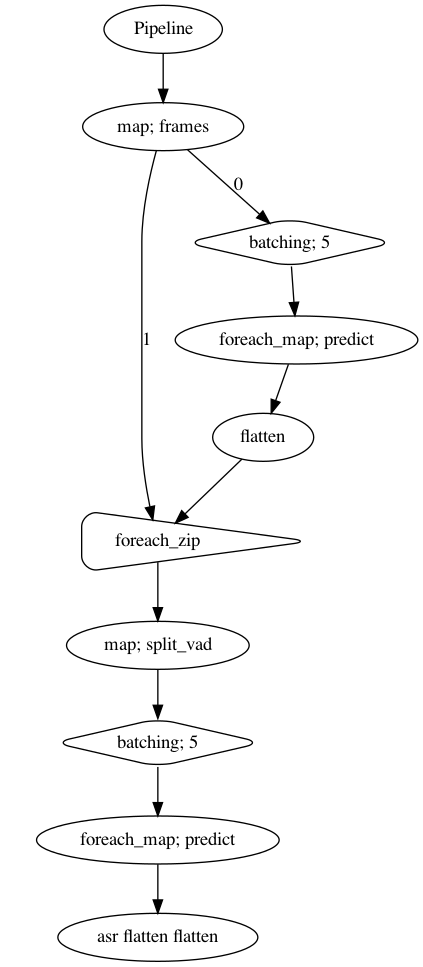

In [22]:
p = Pipeline()

frame = (
    p.map(malaya_speech.utils.generator.frames, frame_duration_ms = 30)
)

vad_map = frame.batching(5).foreach_map(vad.predict).flatten()
foreach = frame.foreach_zip(vad_map)
splitted = foreach.map(malaya_speech.split.split_vad)
asr_map = splitted.batching(5).foreach_map(quantized_model.predict, decoder = 'beam').flatten(name = 'asr-flatten')
p.visualize()

In [23]:
%%time

result = p(samples)
result.keys()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=512 is too small for input signal of length=480
  n_fft, y.shape[-1]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=512 is too small for input signal of length=98
  n_fft, y.shape[-1]


CPU times: user 2min 41s, sys: 32.6 s, total: 3min 13s
Wall time: 1min 9s


dict_keys(['frames', 'batching', 'predict', 'flatten', 'foreach_zip', 'split_vad', 'flatten_asr-flatten'])

In [24]:
result['flatten_asr-flatten']

['hampir 70 peratus pendapatan bulananak rakyat negara ini dibelanjakan untuk berang keperluan perumahan dan pengangkutan',
 'duduk lah perampenk dunia itu juga semakan rendah pedapatan rakyat semakin banyak dia belanjakan mereka untuk makanan ia secara langsung jadikan mereka paling terkesan',
 'apabila berlaku kenakan harga barang untuk golungan kaya pula lagi tingi pendapatan semakin banyak mereka menghabiskan masa lapang dengan melancung dan ke kelabkla rekriasi',
 'namun yang turut perlu diberi perhatian dalam laporan itu ialah pendapatan rakyat malaysia yang statik ketika kasal hidup meningkat',
 'polis kelantan menasarkan peduduk negeritensebut duas pada menghadapi gelombang kedua banji',
 'jadi jangka berlaku 25 dan 26 haribulan ini ramai terutamanya yang mempunya anak kecil bagamas dan wanita hamil demi ta sentiasa bersiar sediam',
 'tidak akan berpindah epada bila-bila masa meneka ladi kota tingi johor',
 'lebih 70 penduduk berlindung dilima pusa pemindahan didierah itu keben

In [18]:
import IPython.display as ipd
ipd.Audio(result['split_vad'][-4].array, rate = 16000)